In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
rng = np.random.default_rng()

In [19]:
import kurvy

In [20]:
# CONFIG
scale_min = 0
scale_max = 1
train_test_split = (85,15)

## Data Prep

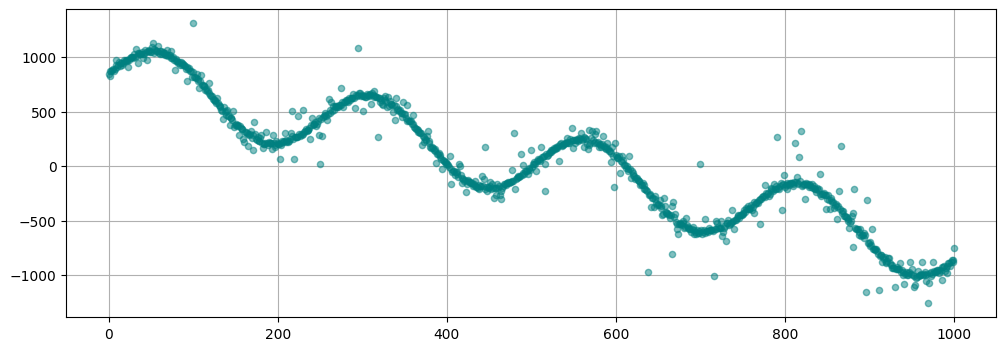

In [21]:
# df = pd.read_csv("weight.csv",header=None).rename(columns={0:"date",1:"kg"})
# X_raw = np.array(df.index)
# Y_raw = np.array(df["kg"])
real_params, X_raw, Y_raw = kurvy.trig.make_data((0,1000),1000,fuzz=3,seed=66)
kurvy.plots.simple_plot(X_raw, Y_raw)

In [22]:
# scale X data
X_raw_min = np.min(X_raw)
X_raw_max = np.max(X_raw)
X = kurvy.utils.min_max_scale(X_raw,scale_min,scale_max,X_raw_min,X_raw_max)
# scale Y data
Y_raw_min = np.min(Y_raw)
Y_raw_max = np.max(Y_raw)
Y = kurvy.utils.min_max_scale(Y_raw,scale_min,scale_max,Y_raw_min,Y_raw_max)
# combine X and Y data
XY = np.dstack((X,Y))[0]

In [23]:
# shuffle data
shuffle_idxs = rng.choice(XY.shape[0],XY.shape[0],replace=False)
XY = XY[shuffle_idxs]

In [24]:
# split data
splits = kurvy.utils.split_n(XY.shape[0],train_test_split)
XY_train = XY[:splits[0]]
X_train = XY_train[:,0]
Y_train = XY_train[:,1]
XY_test = XY[splits[0]:]
# sorted data for plots
X_train_sorted = XY_train[np.argsort(XY_train[:,0])][:,0]
Y_train_sorted = XY_train[np.argsort(XY_train[:,0])][:,1]

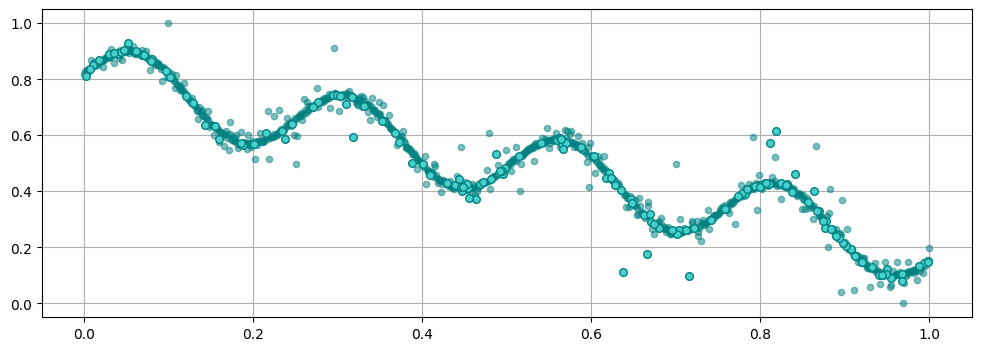

In [25]:
kurvy.utils.simple_plot(X_train_sorted,Y_train_sorted,test_data=XY_test)

## Training

In [26]:
# # parameter initialization: ballpark
# initial_params = {
#     "a":{"value":0.2,"trainable":True},
#     "b":{"value":0.45,"trainable":True},
#     "c":{"value":0.2,"trainable":True},
#     "d":{"value":None,"trainable":True},
#     "e":{"value":None,"trainable":True}
# }
# # create model
# tm = utils.TrigModel(initial_params=initial_params,seed=33)

In [27]:
# parameter initialization
initializer = rng.normal(-10,10,size=5)
# create model
tm = kurvy.trig.TrigModel(initializer=initializer,seed=42)

### Untrained model

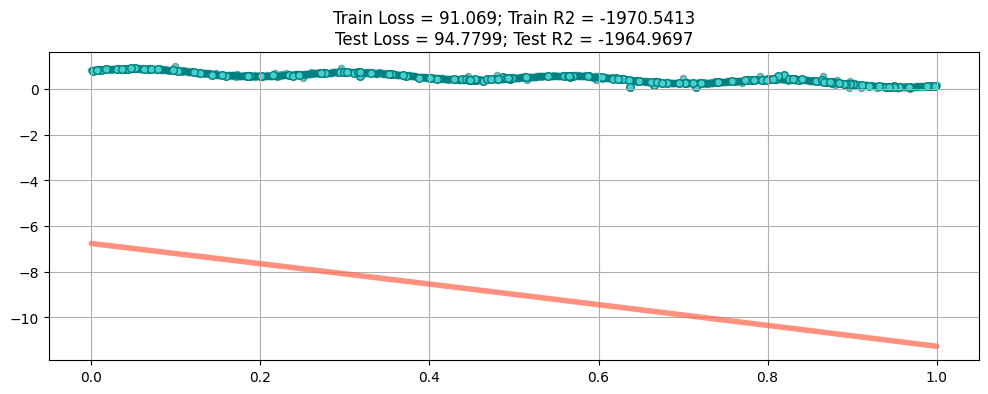

In [28]:
kurvy.plots.pred_plot(tm,X_train_sorted,Y_train_sorted,test_data=XY_test)

### Regression for parameters `d` and `e`

In [29]:
trend,offset = kurvy.utils.lin_reg(X_train,Y_train)
print(f"Trend: {trend}")
print(f"Offset: {offset}")

Trend: -0.678201930648263
Offset: 0.8416522509671418


In [30]:
tm.params["d"]["value"] = offset
tm.params["d"]["trainable"] = False
tm.params["e"]["value"] = trend
tm.params["e"]["trainable"] = False

### Training run

Initial Loss: 1.277396052820376


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 597.28it/s]

Final Loss: 0.01076030528275359


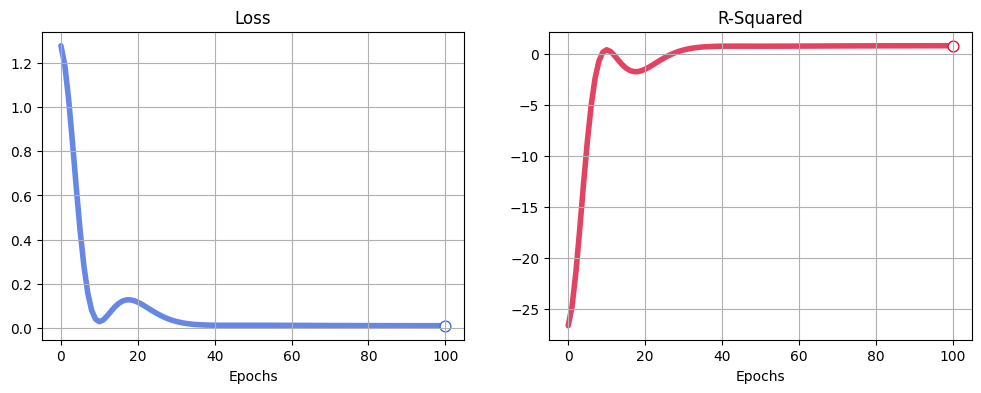

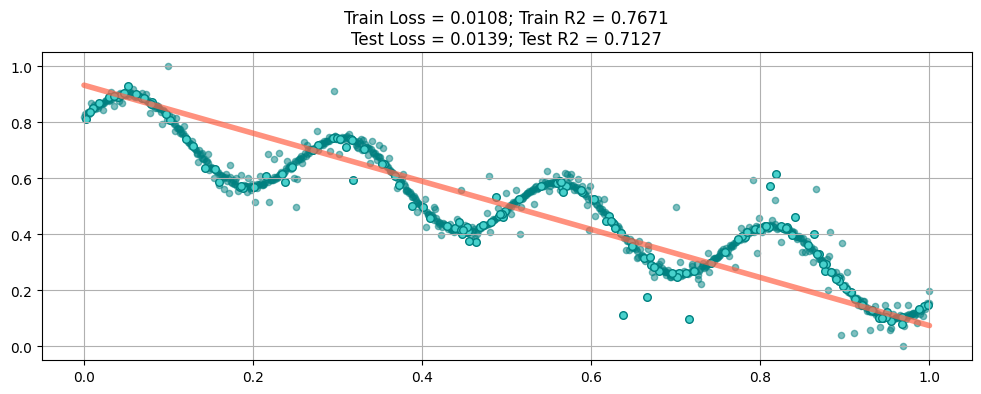

In [31]:
tm.fit(
    X_train,
    Y_train,
    epochs=100,
    learning_rate=0.01,
    momentum=0.9,
    save_best=True
)
kurvy.plots.plot_training(tm,"both")
kurvy.plots.pred_plot(tm,X_train_sorted,Y_train_sorted,test_data=XY_test)

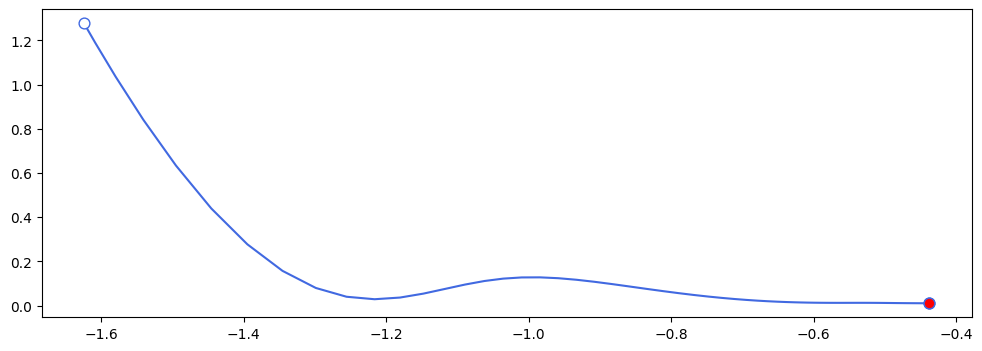

In [32]:
kurvy.plots.loss_vis(tm,"a",markers=False)

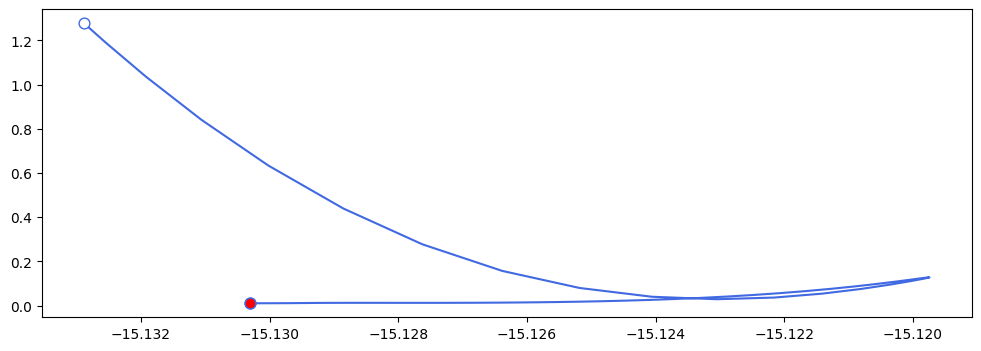

In [33]:
kurvy.plots.loss_vis(tm,"b",markers=False)

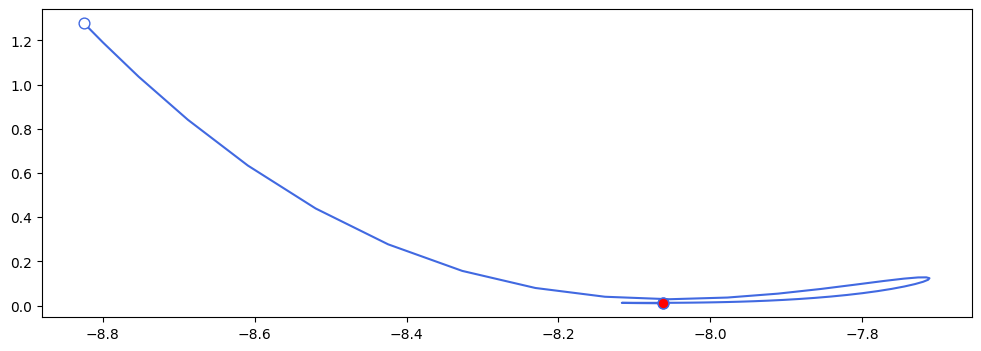

In [34]:
kurvy.plots.loss_vis(tm,"c",markers=False)

## Descale Parameters

In [35]:
a = tm.params["a"]["value"]
b = tm.params["b"]["value"]
c = tm.params["c"]["value"]
d = tm.params["d"]["value"]
e = tm.params["e"]["value"]

In [36]:
alpha_x = X_raw_max - X_raw_min
beta_x = X_raw_min
alpha_y = Y_raw_max - Y_raw_min
beta_y = Y_raw_min

In [37]:
a_pred = a * alpha_y
b_pred = b * alpha_x + beta_x
c_pred = c
d_pred = alpha_y * (d - e*beta_x/alpha_x) + beta_y
e_pred = alpha_y * e / alpha_x

In [38]:
a_real, b_real, c_real, d_real, e_real = real_params
for param in [
    ("a",a_real,a_pred),
    ("b",b_real,b_pred),
    ("c",c_real,c_pred),
    ("d",d_real,d_pred),
    ("e",e_real,e_pred),
]:
    p_real = np.round(param[1],3)
    p_pred = np.round(param[2],3)
    dif = np.round(p_real - p_pred,3)
    dif_pct = np.round(dif/p_real*100,2)
    
    print(f"{param[0]}\treal: {p_real}\tpred: {p_pred}")  

a	real: 317.629	pred: -1125.185
b	real: 254.073	pred: -15130.297
c	real: 692.624	pred: -8.063
d	real: 824.849	pred: 904.583
e	real: -1.589	pred: -1.744
